In [1]:
%run notebook_config

theano version: 1.0.4
pymc3 version: 3.7


# Gaussian processes

`caustic` enables the use of [Gaussian Processes](https://distill.pub/2019/visual-exploration-gaussian-processes/) for modeling correlated noise. The basic idea behind GPs is to extend the covariance matrix of the multivariate gaussian likelihood we've used in the previous tutorial and model the covariance matrix terms by means of a kernel function
which depends on the difference between any two time points at which we measured the flux. That is
   
$$\kappa(t)=\kappa \,(|t-t'|)$$

Such a kernel is said to be stationary because it defines a stationary gaussian process. The covariance matrix terms are then

$$
\boldsymbol{\Sigma}_{i, j}=\kappa\left(|t_{i}- t_{j}|\right)+\sigma_{i}^{2} \delta_{i, j}
$$

where $\sigma_i$ are the "error bars" provided by photometry reduction pipelines. Because the covariance matrix is no longer diagonal, and the likelihood function involves computing its inverse and the determinant, naive implementations are extremely costly because the computation of a matrix inverse scales like $\mathcal{O}(N^3)$. Fortunately, the recent
package [celerité](https://celerite.readthedocs.io/en/stable/) enables computation of the gaussian process likelihood in linear time. It does this by restricting the application of GPs to one-dimensional data and a special class of kernel functions which result enable efficient computation of the inverse and the determinant of the covariance matrix. The restricted class of kernels is still sufficient for use in microlensing data. 

For more info on celerité, see the package documentation and the associated [paper](https://ui.adsabs.harvard.edu/abs/2017AJ....154..220F/abstract).

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


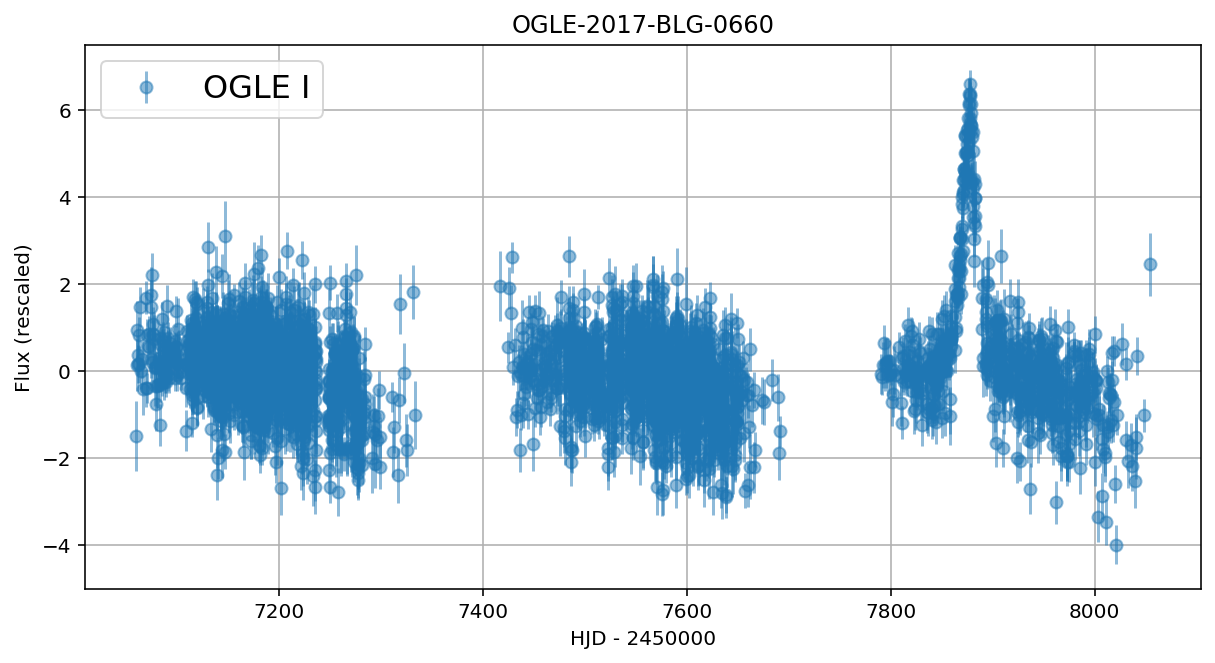

In [2]:
import numpy as np
from matplotlib import pyplot as plt

import pymc3 as pm
import theano.tensor as T

import caustic as ca
import exoplanet as xo

np.random.seed(42)

event_ogle = ca.data.OGLEData("../../data/OGLE-2017-BLG-0660")

fig, ax = plt.subplots(figsize=(10, 5))
event_ogle.plot_standardized_data(ax)

Let's first fit a model with a diagonal covariance matrix.

In [3]:
# Initialize a SingleLensModel object
model = ca.models.SingleLensModel(event_ogle) 

In [4]:
n_bands = len(event_ogle.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.) 
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with model:
    # Flux parameters 
    Delta_F = BoundedNormal('Delta_F', 
        mu=T.zeros(n_bands),
        sd=50.*T.ones(n_bands),
        testval=5.*T.ones(n_bands),
        shape=(n_bands))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=0.6*T.ones(n_bands),
        testval=T.zeros(n_bands),
        shape=(n_bands))
    
    # Other parameters
    t_0 = pm.Uniform('t_0', model.t_min, model.t_max,
        testval=ca.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    teff = BoundedNormal('t_eff', mu=0., sd=365., testval=20.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", teff/u_0) 
    m_source, g = ca.compute_source_mag_and_blend_fraction(event_ogle, Delta_F, F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(model.t)
    
    # Compute the magnification
    mag = model.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = Delta_F*mag + F_base
    
    # Let's allow for rescaling of the error bars by a constant factor plus an additive term
    c_1 = BoundedNormal_1('c_1', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))
    
    c_2 = BoundedNormal('c_2', 
        mu=T.ones(n_bands),
        sd=1.*T.ones(n_bands),
        testval=0.1*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c_1*model.sig_F)**2 + c_2**2
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model.compute_log_likelihood(model.F - mean, var_F)
    pm.Potential('log_likelihood', ll)

In [5]:
with model:
    # Print initial logps
    initial_logps = [RV.logp(model.test_point) for RV in model.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace = pm.sample(tune=500, draws=1000, cores=4, step=xo.get_dense_nuts_step(target_accept=0.9))

Initial values of log priors: [array(-3.226523626198718), array(-0.40811290943868195), array(-1.9150459978644268), array(-3.6292109565291044), array(-3.8246048329742135), array(-2.3364828943245635), array(-3.6265236261987184)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_2, c_1, t_eff, u_0, t_0, F_base, Delta_F]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:43<00:00, 138.68draws/s]


In [6]:
pm.summary(trace)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
F_base__0,-0.028539,0.010563,0.000154,-0.047904,-0.007011,4260.096203,0.999918
Delta_F__0,5.784226,0.123989,0.002131,5.555949,6.036449,3536.057782,0.999564
t_0,7876.710828,0.220582,0.003272,7876.312654,7877.176656,4073.628112,1.000455
u_0,1.399162,0.787524,0.020017,0.370008,3.009168,1390.749608,1.001401
t_eff,9.667308,1.609749,0.034296,6.626135,12.391018,1921.772646,1.000393
t_E,8.378444,2.918968,0.063142,3.121748,13.654347,1945.563090,1.000787
m_source__0,17.408181,1.383520,0.033249,14.677725,19.677086,1574.851385,1.001109
g__0,-0.631679,0.363354,0.007016,-0.998125,0.092852,2302.900529,1.000341
c_1__0,1.809148,0.020804,0.000360,1.770604,1.852834,3786.431044,0.999889
c_2__0,0.036026,0.026514,0.000470,0.000147,0.087866,3066.397766,0.999705


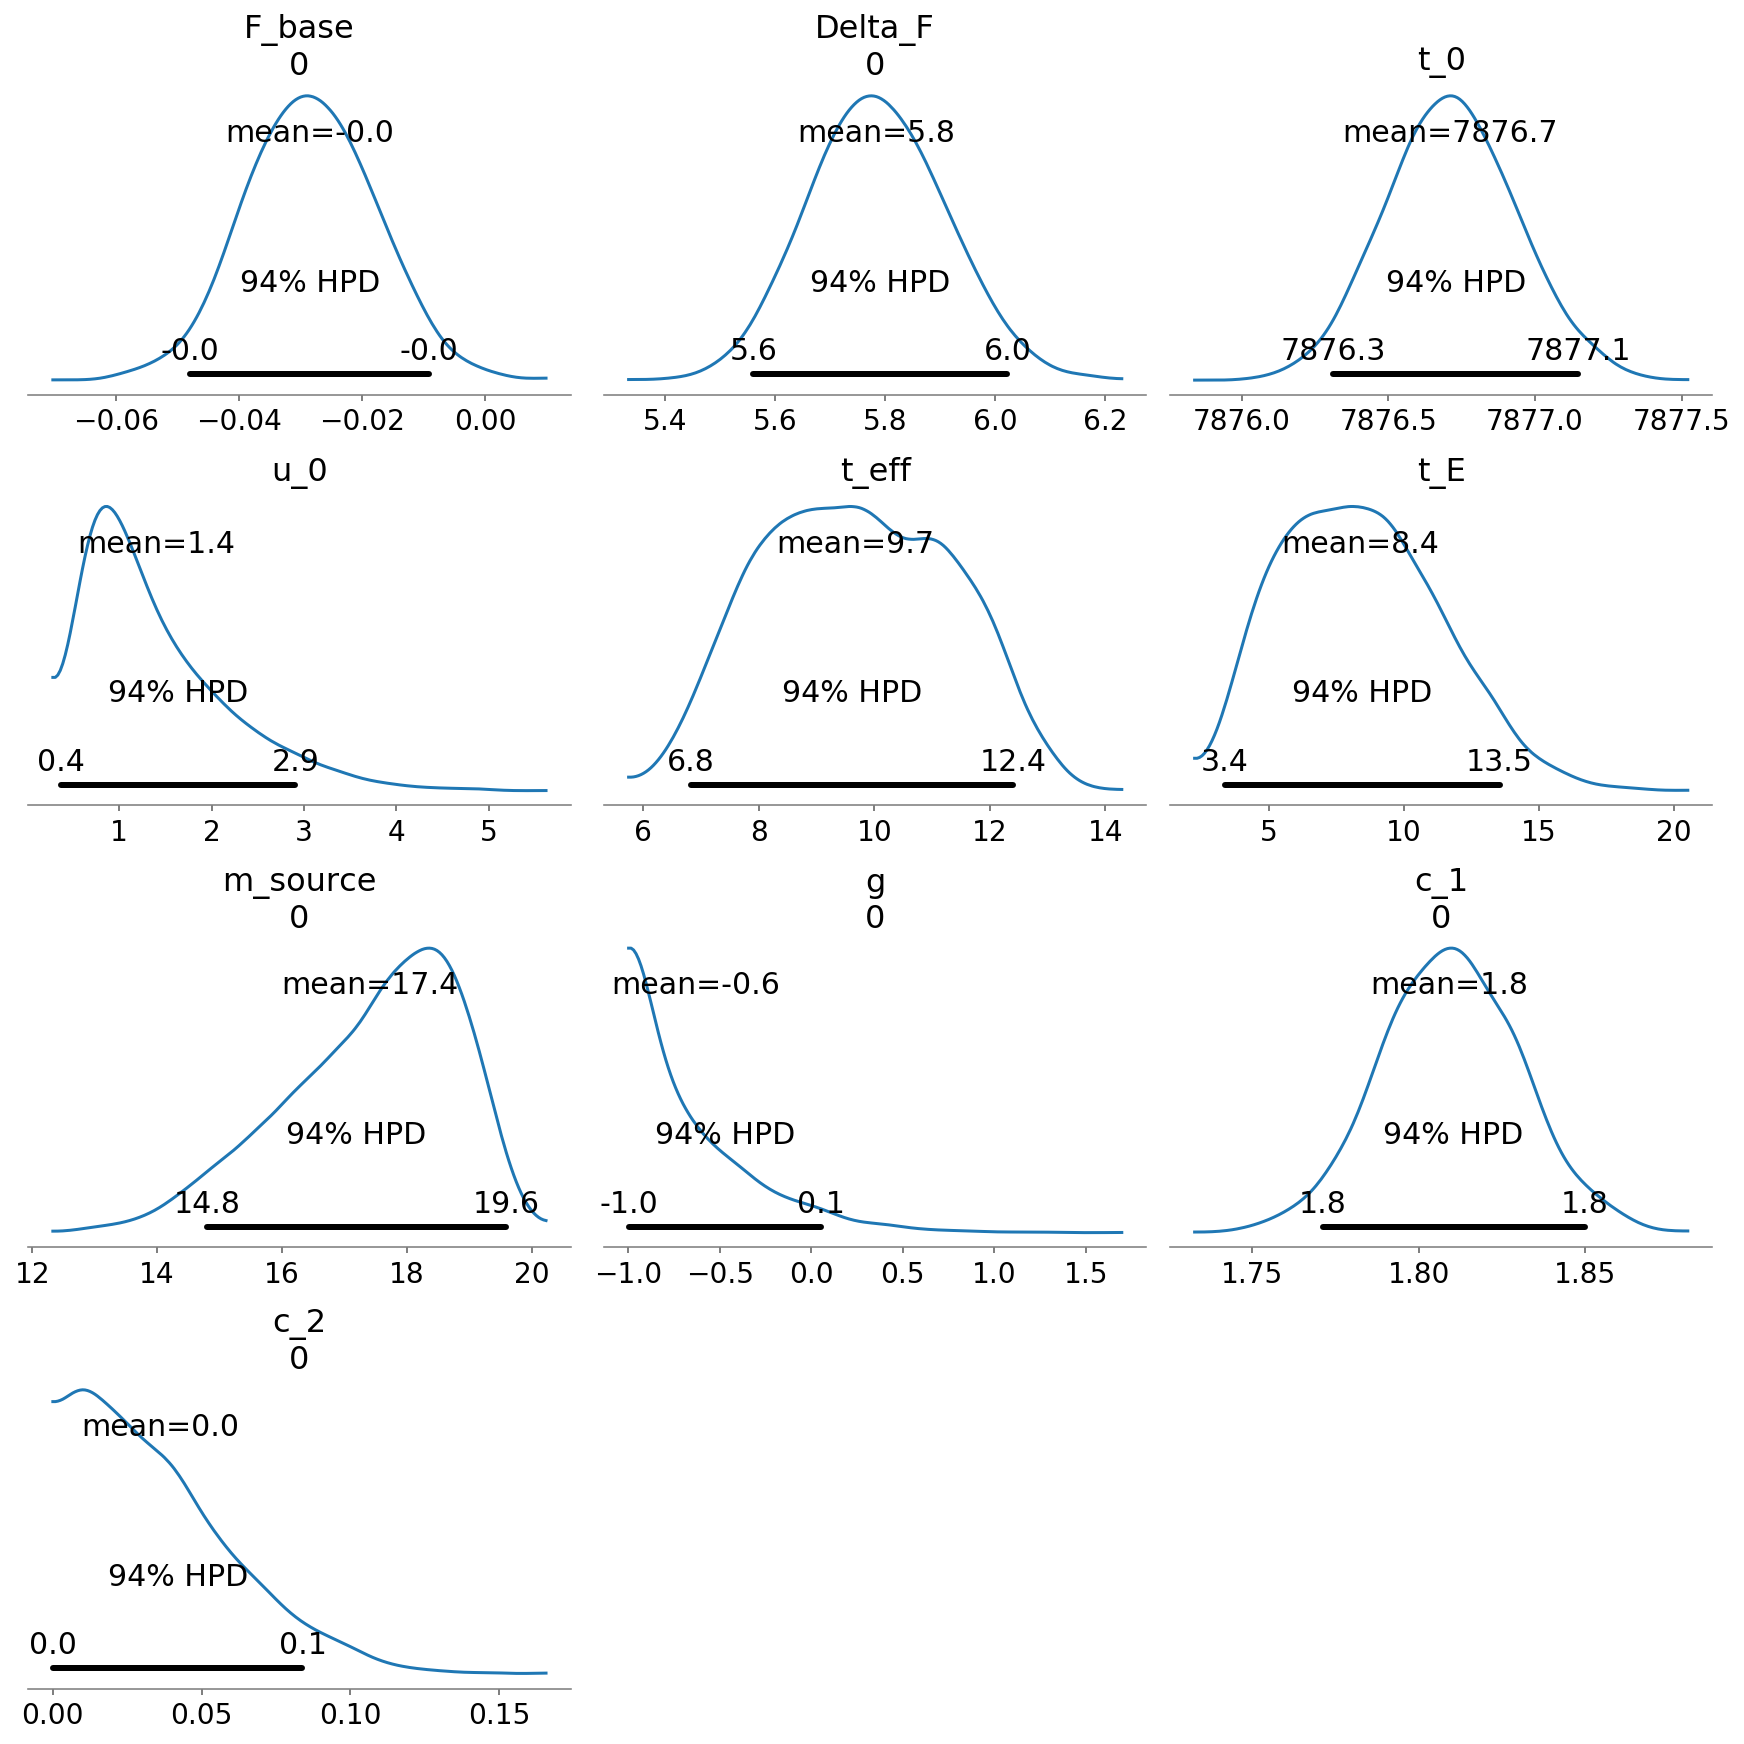

In [24]:
pm.plot_posterior(trace, figsize=(12, 12));

In [8]:
with model:
    # Create dense grid
    t_dense = np.tile(np.linspace(model.t_min, model.t_max, 2000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)
    
    # Compute the magnification
    mag_dense = model.compute_magnification(u_dense, u_0)
    
    # Compute the mean model
    mean_dense = Delta_F*mag_dense + F_base

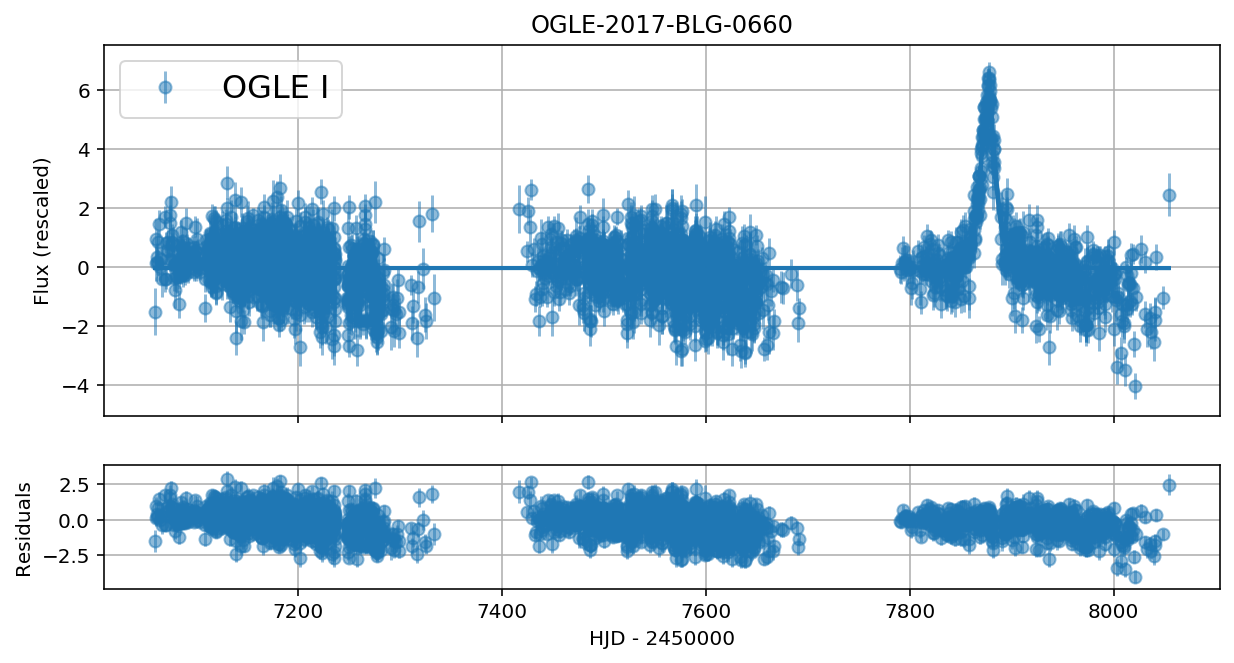

In [9]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(10, 5), sharex=True)

ca.plot_model_and_residuals(ax, event_ogle, model, trace, t_dense_tensor, mean_dense, n_samples=50)

We can see clear correlations in the residuals which aren't accounted for by the model. To expand the model we include a GP.

In [10]:
# Initialize a SingleLensModel object
model_gp = ca.models.SingleLensModel(event_ogle) 

In [11]:
n_bands = len(event_ogle.light_curves)
BoundedNormal = pm.Bound(pm.Normal, lower=0.) 
BoundedNormal_1 = pm.Bound(pm.Normal, lower=1.) 

with model_gp:
    # Flux parameters 
    Delta_F = BoundedNormal('Delta_F', 
        mu=T.zeros(n_bands),
        sd=50.*T.ones(n_bands),
        testval=5.*T.ones(n_bands),
        shape=(n_bands, 1))

    F_base = pm.Normal('F_base', 
        mu=T.zeros(n_bands), 
        sd=0.6*T.ones(n_bands),
        testval=T.zeros(n_bands),
        shape=(n_bands))
    
    # Other parameters
    t_0 = pm.Uniform('t_0', model_gp.t_min, model_gp.t_max,
        testval=ca.estimate_t0(event_ogle))
    
    u_0 = BoundedNormal('u_0', mu=0., sd=1.5, testval=0.1)
    
    teff = BoundedNormal('t_eff', mu=0., sd=365., testval=20.)
    
    # Deterministic transformations
    t_E = pm.Deterministic("t_E", teff/u_0) 
    m_source, g = ca.compute_source_mag_and_blend_fraction(event_ogle, Delta_F, F_base, u_0)
    pm.Deterministic("m_source", m_source)
    pm.Deterministic("g", g)
    
    # Compute the trajectory of the lens
    trajectory = ca.trajectory.Trajectory(event_ogle, t_0, u_0, t_E)
    u = trajectory.compute_trajectory(model_gp.t)
    
    # Compute the magnification
    mag = model_gp.compute_magnification(u, u_0)
    
    # Compute the mean model
    mean = Delta_F*mag + F_base
    
    # Let's allow for rescaling of the error bars by a constant factor plus an additive term
    c_1 = BoundedNormal_1('c_1', 
        mu=T.ones(n_bands),
        sd=2.*T.ones(n_bands),
        testval=1.5*T.ones(n_bands),
        shape=(n_bands))
    
    c_2 = BoundedNormal('c_2', 
        mu=T.ones(n_bands),
        sd=1.*T.ones(n_bands),
        testval=0.1*T.ones(n_bands),
        shape=(n_bands))

    # Diagonal terms of the covariance matrix
    var_F = (c_1*model_gp.sig_F)**2 + c_2**2

We'll use the version of `celerite` implemented in the `exoplanet` code because it naturaly interfaces with `PyMC3` and provides gradient of the log likelihood with respect to the GP hyperparameters which is what we need for HMC to work. For more details check out the [exoplanet docs](https://exoplanet.dfm.io/en/latest/tutorials/gp/). We'll use the `exoplanet.gp.terms.Matern32` because it is a sensible default. This kernel is defined by two parameters, the characteristic lengthscale $\rho$ (in our case $\rho$ has dimensions of time since we're dealing with time series data), and $\sigma$ which controls the spread in the dependent variable (the flux). We have to be caref about choosing priors for the lengthscale parameter because GPs are somewhat prone to overfitting. Following the suggestions in this [Stan case study](https://betanalpha.github.io/assets/case_studies/gp_part1/part1.html), we opt to use an Inverse Gamma prior for $\rho$ which assigns 1\% probability to timescales less than the median separation between consecutive data points and 1\% probability to lengthscales larger than the entire duration of the time series. This is a sensible prior because it prevents the model from converging to timescales for which there is justification in the data. To compute the parameters of the Inverse Gamma distribution which satisfy the above requirements, we use the function `ca.compute_invgama_params`.


In [12]:
with model_gp:   
    # Compute parameters for the prior
    invgamma_a, invgamma_b = ca.compute_invgamma_params(event_ogle)
    
    # Initialize the GP parameters for the Matern32 kernel
    sigma_gp = BoundedNormal('sigma_gp', 
        mu=T.zeros(n_bands),
        sd=3.*T.ones(n_bands),
        testval=0.5*T.ones(n_bands),
        shape=(n_bands, 1))
    
    rho_gp = BoundedNormal('rho_gp', 
        mu=T.zeros(n_bands),
        sd=100.*T.ones(n_bands),
        testval=2.*T.ones(n_bands),
        shape=(n_bands))
    
    # List for storing xo.gp.GP objects 
    gp_list = []
    
    for n in range(n_bands):
        kernel = xo.gp.terms.Matern32Term(sigma=sigma_gp[n], rho=rho_gp[n])
        gp_list.append(xo.gp.GP(kernel, model_gp.t[n], var_F[n], J=2)) 
    
    # Compute the Gaussian log_likelihood, add it as a potential term to the model
    ll = model_gp.compute_log_likelihood(model_gp.F - mean, var_F, gp_list)
    pm.Potential('log_likelihood', ll)

/anaconda3/envs/pymc3/lib/python3.6/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [13]:
with model_gp:
    # Print initial logps
    initial_logps = [RV.logp(model_gp.test_point) for RV in model_gp.basic_RVs]
    print("Initial values of log priors:", initial_logps)
    
    # Run sampling
    trace_gp = pm.sample(tune=500, draws=2000, cores=4, 
                      step=xo.get_dense_nuts_step(target_accept=0.9))

Initial values of log priors: [array(-3.226523626198718), array(-0.40811290943868195), array(-1.9150459978644268), array(-3.6292109565291044), array(-3.8246048329742135), array(-2.3364828943245635), array(-3.6265236261987184), array(-2.724586891321617), array(-4.831161538632819)]


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rho_gp, sigma_gp, c_2, c_1, t_eff, u_0, t_0, F_base, Delta_F]
Sampling 4 chains: 100%|██████████| 10000/10000 [02:39<00:00, 62.68draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [14]:
pm.summary(trace_gp)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
F_base__0,-0.174436,0.089125,0.000967,-0.353731,-0.000110,7429.259705,1.000112
Delta_F__0_0,5.928321,0.455487,0.004925,5.032455,6.786827,7443.651863,1.000242
t_0,7876.790412,0.406541,0.005148,7875.970865,7877.592472,6514.684689,1.000067
u_0,1.050921,0.828594,0.009004,0.073730,2.755656,6773.157018,1.000011
t_eff,8.436326,1.928843,0.022563,5.246298,12.111926,5844.764548,0.999823
t_E,13.212752,10.607351,0.168136,2.504233,31.534879,3686.610957,1.000677
m_source__0_0,18.276125,1.744864,0.020078,14.840236,21.332851,6172.160384,0.999947
g__0_0,0.167627,1.851296,0.029088,-0.999232,3.258003,3774.080126,1.000535
c_1__0,1.631395,0.019406,0.000220,1.592023,1.668510,6535.876199,0.999878
c_2__0,0.037678,0.027524,0.000366,0.000007,0.089593,5251.262117,1.000181


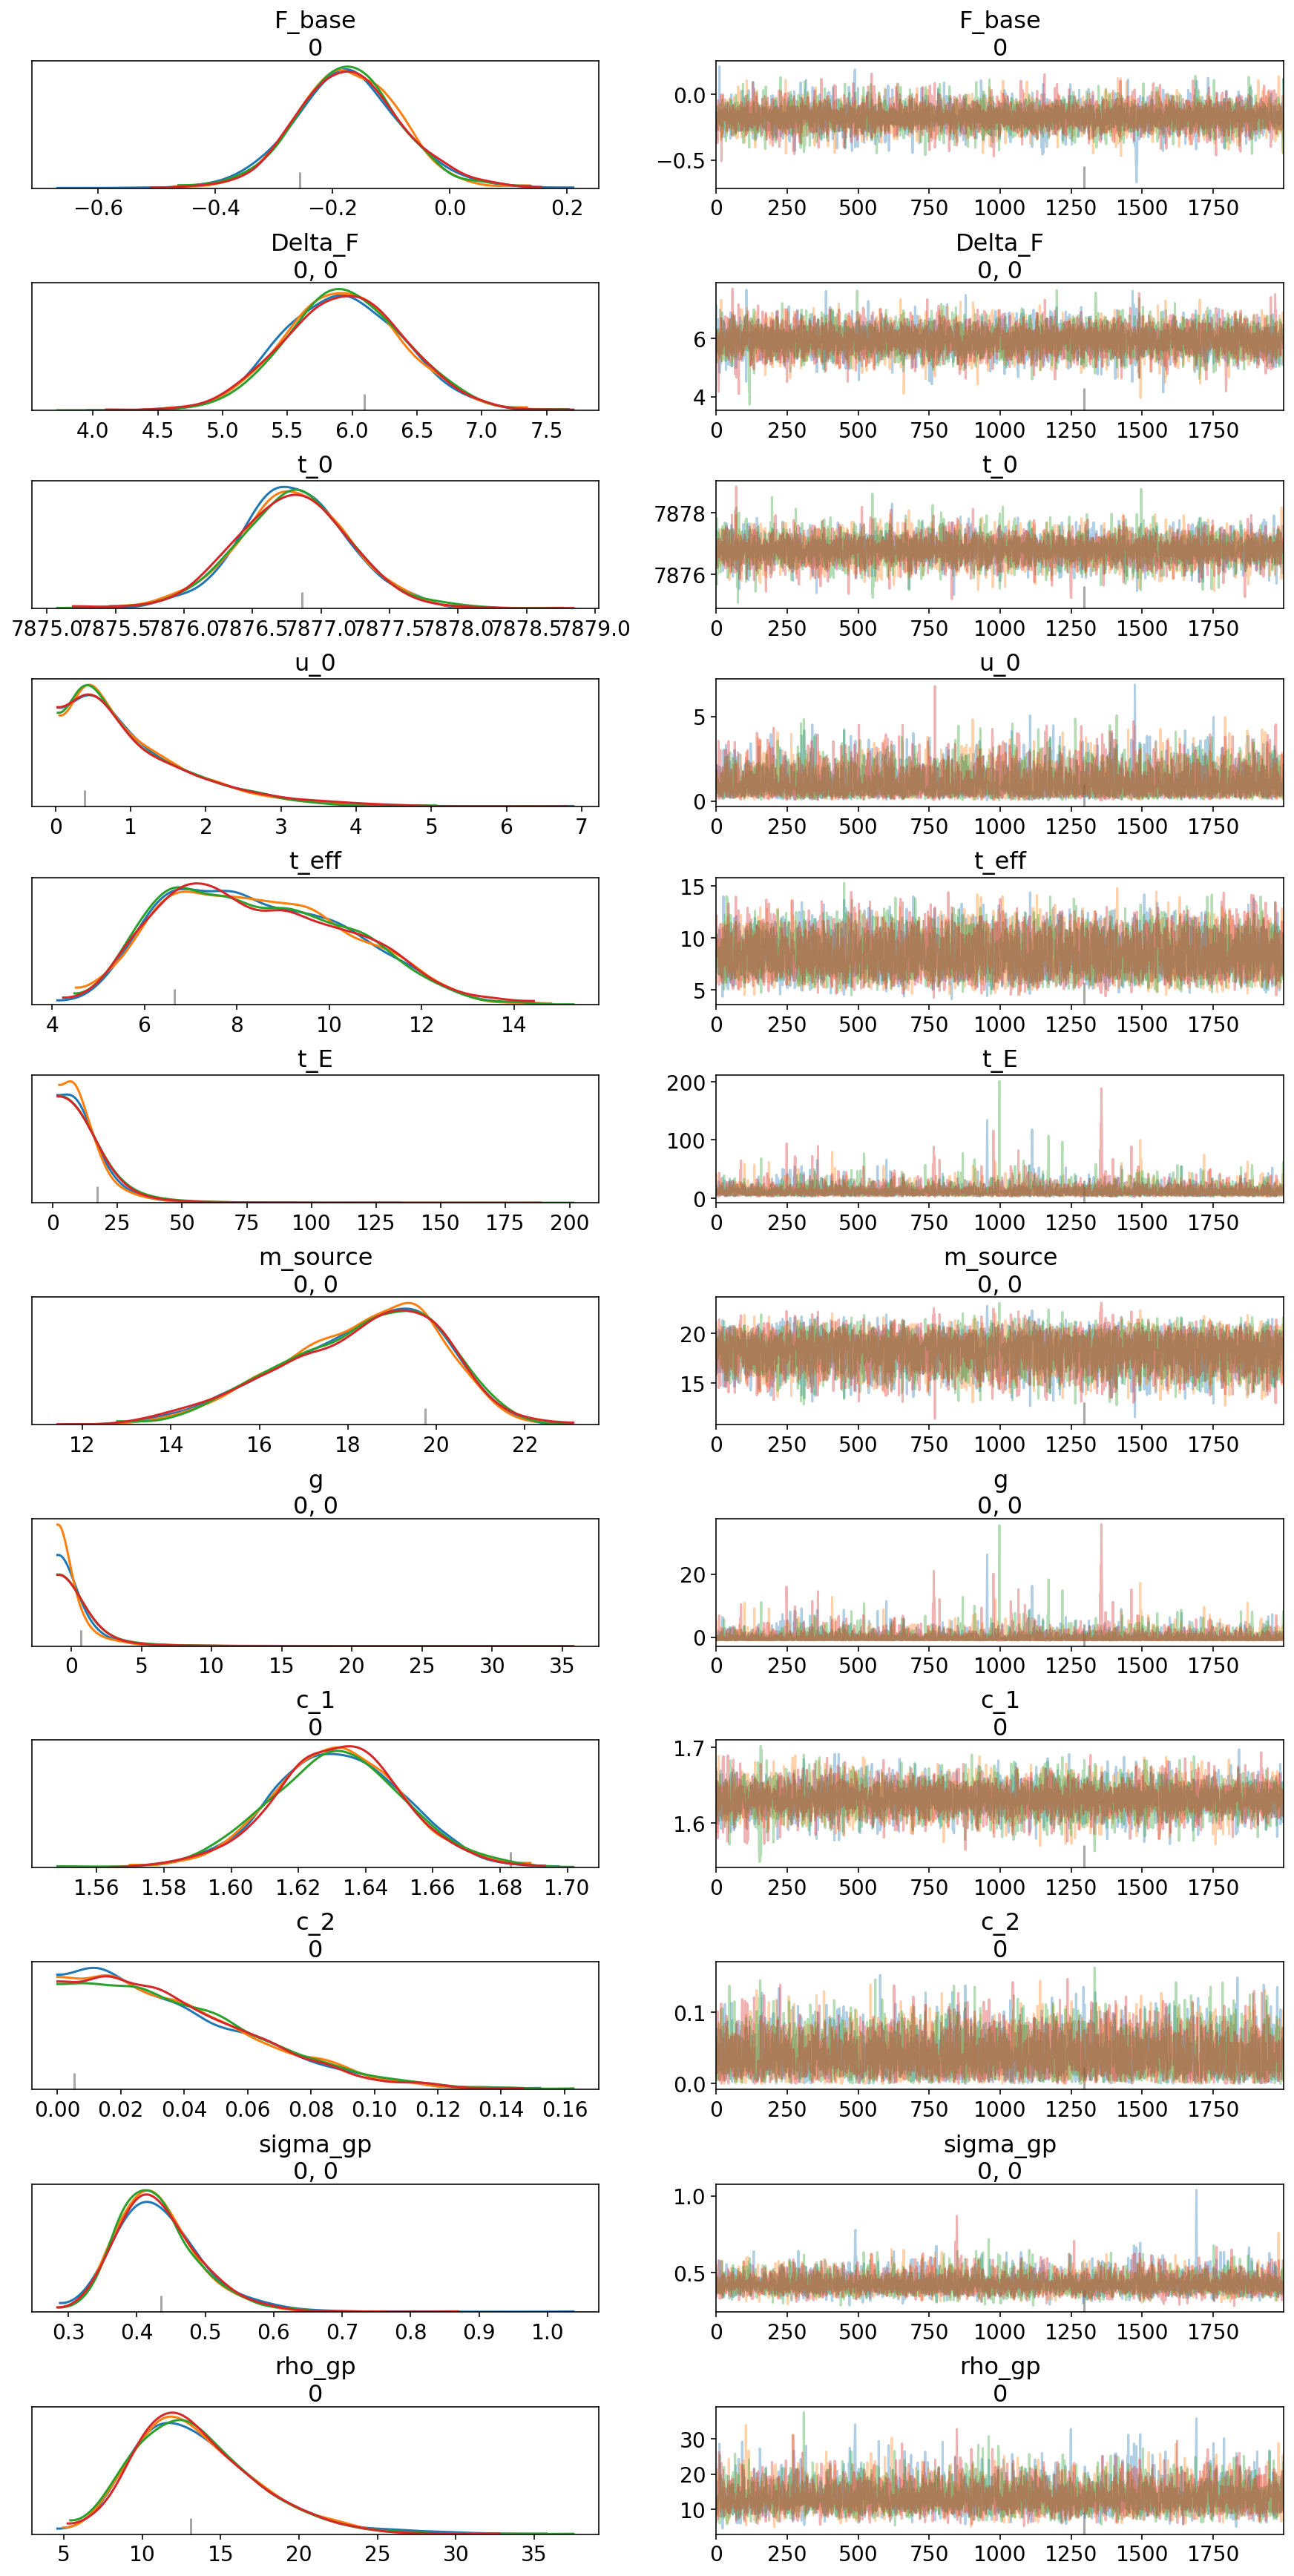

In [15]:
pm.traceplot(trace_gp);

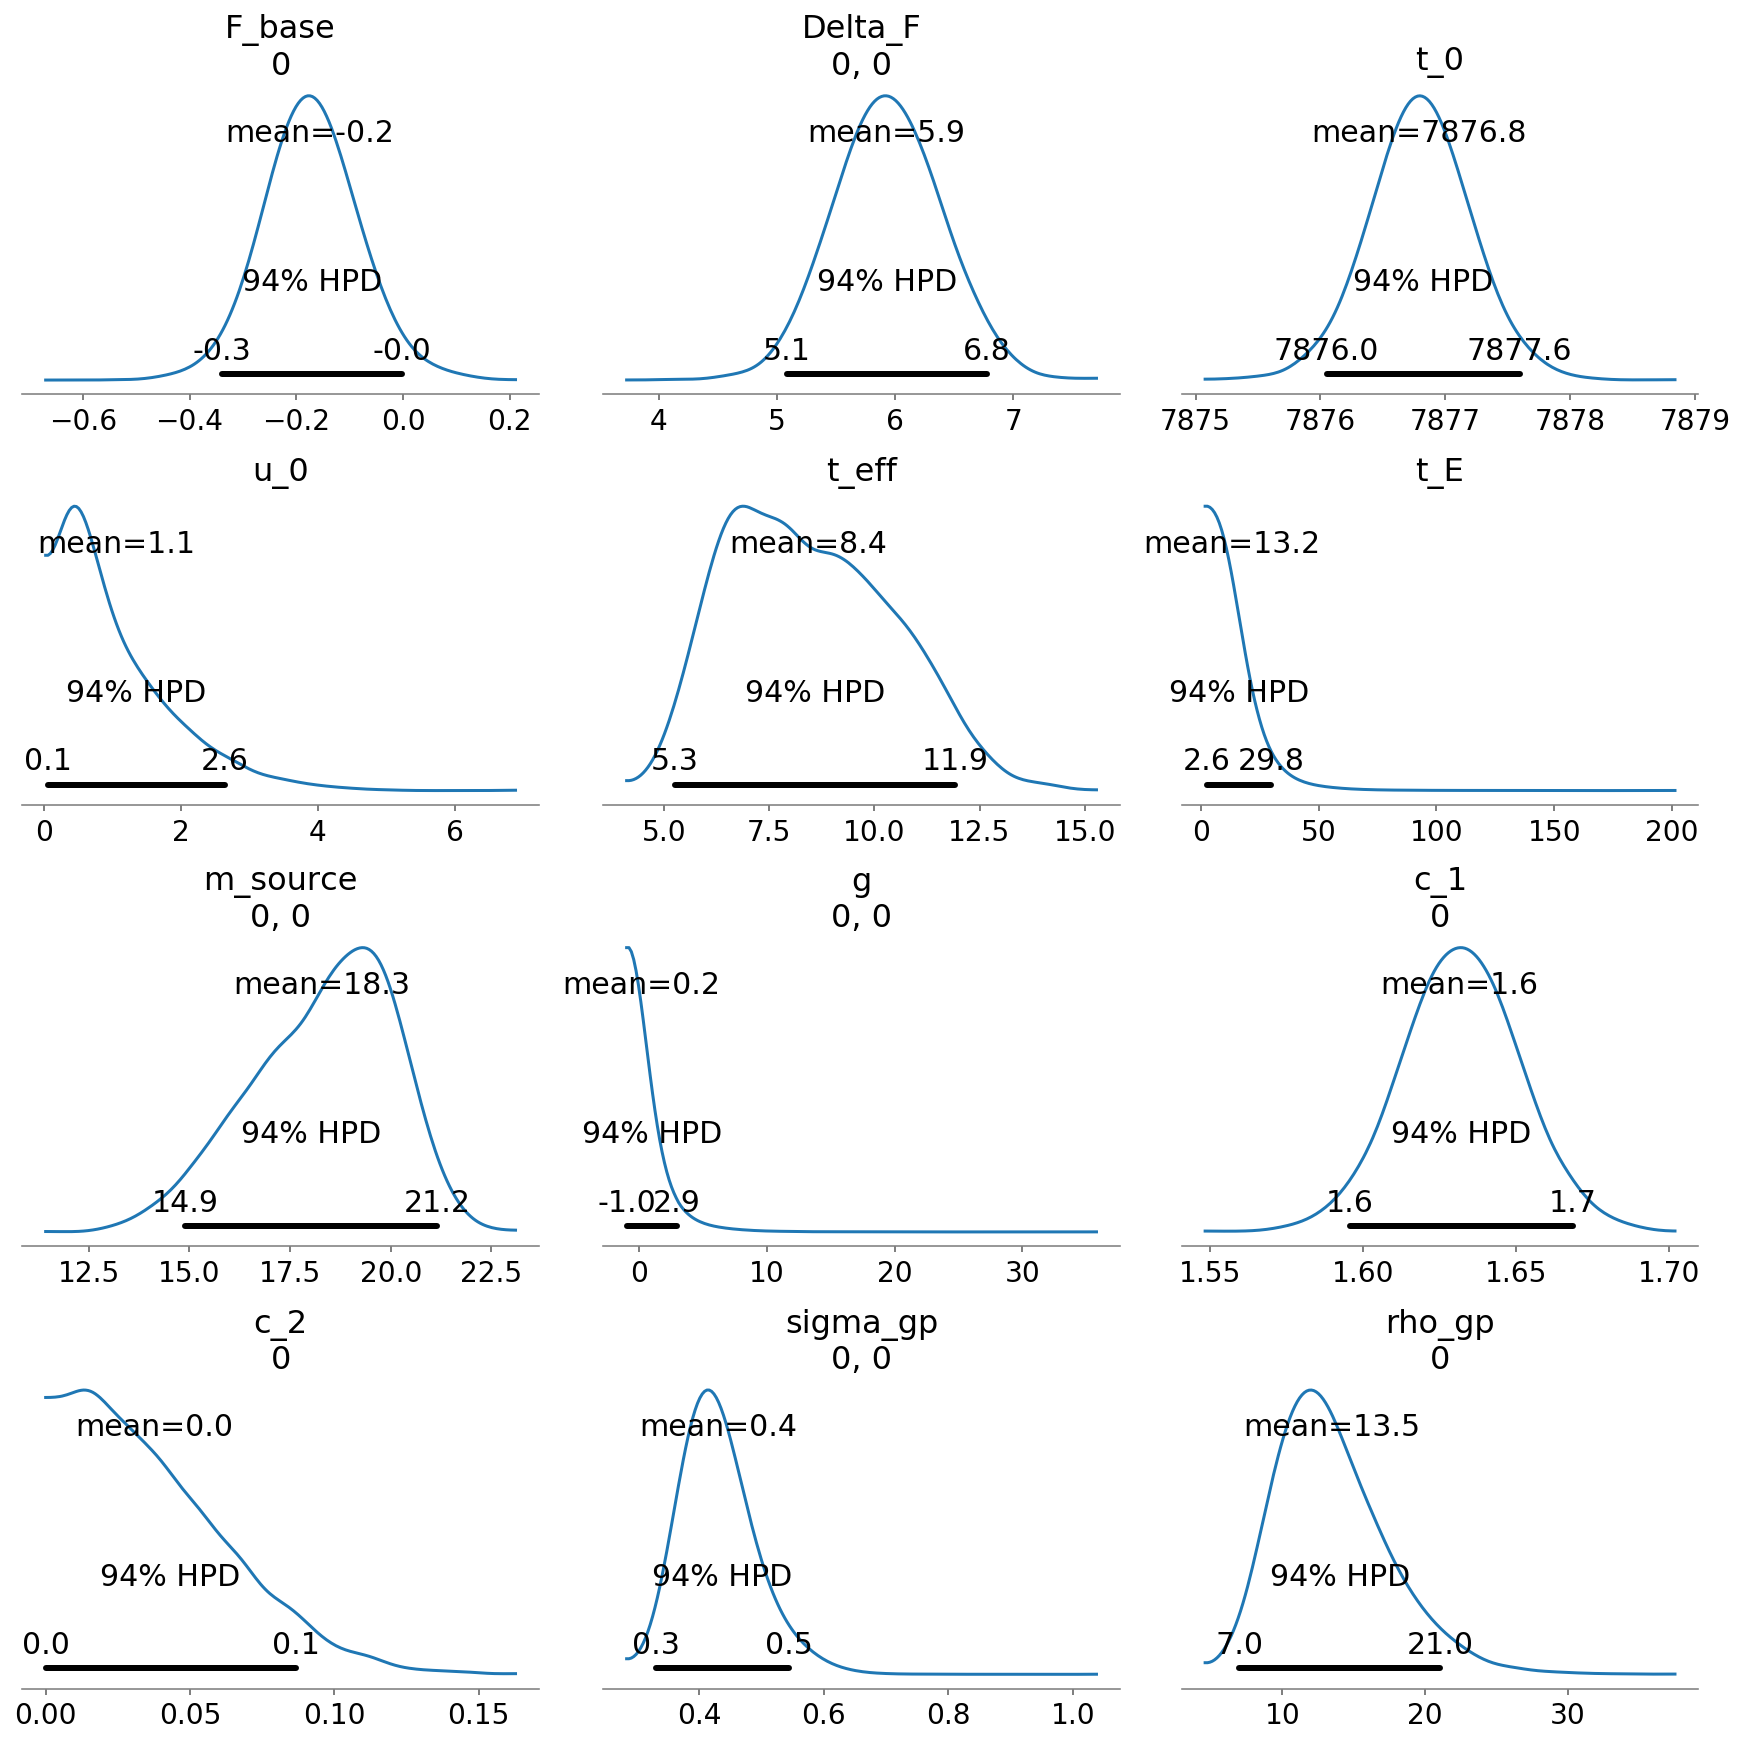

In [25]:
pm.plot_posterior(trace_gp, figsize=(12, 12));

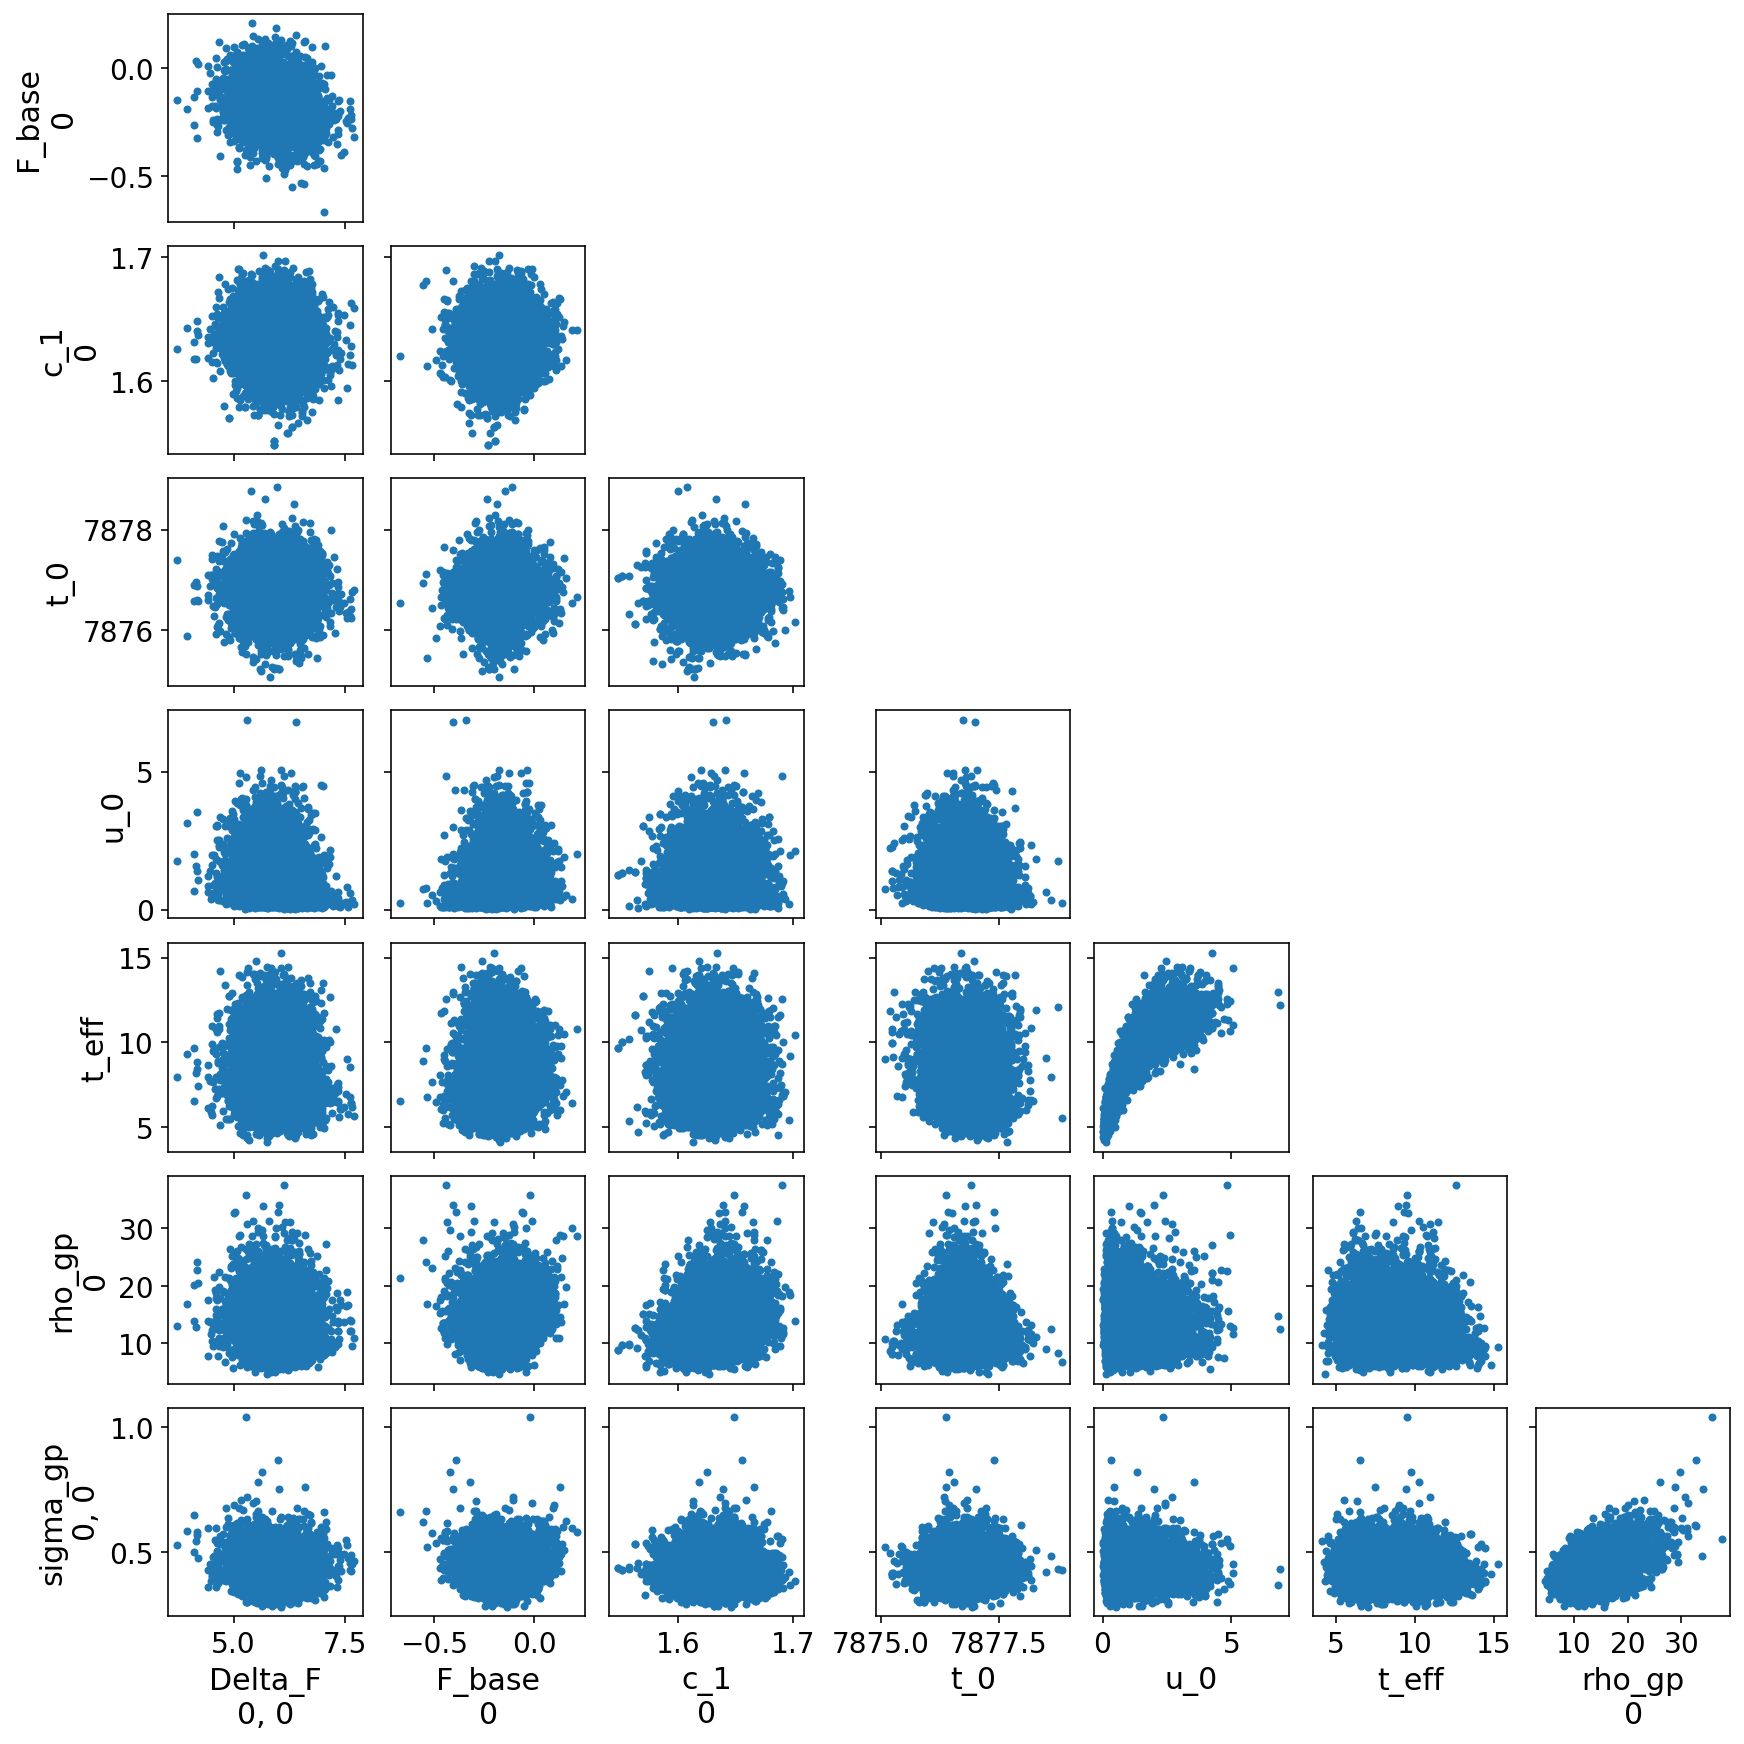

In [27]:
pm.pairplot(trace_gp, figsize=(12, 10),
            var_names=['Delta_F', 'F_base', 'c_1', 't_0', 'u_0', 't_eff', 'rho_gp', 'sigma_gp']);

Let's plot the model

In [18]:
with model_gp:
    # Create dense grid
    t_dense = np.tile(np.linspace(model_gp.t_min, model_gp.t_max, 1000), (n_bands, 1))
    t_dense_tensor = T.as_tensor_variable(t_dense) 
    
    # Compute the trajectory of the lens
    u_dense = trajectory.compute_trajectory(t_dense_tensor)
    
    # Compute the magnification
    mag_dense = model_gp.compute_magnification(u_dense, u_0)
    
    # Compute the mean model
    mean_dense = Delta_F*mag_dense + F_base

This will take some time...

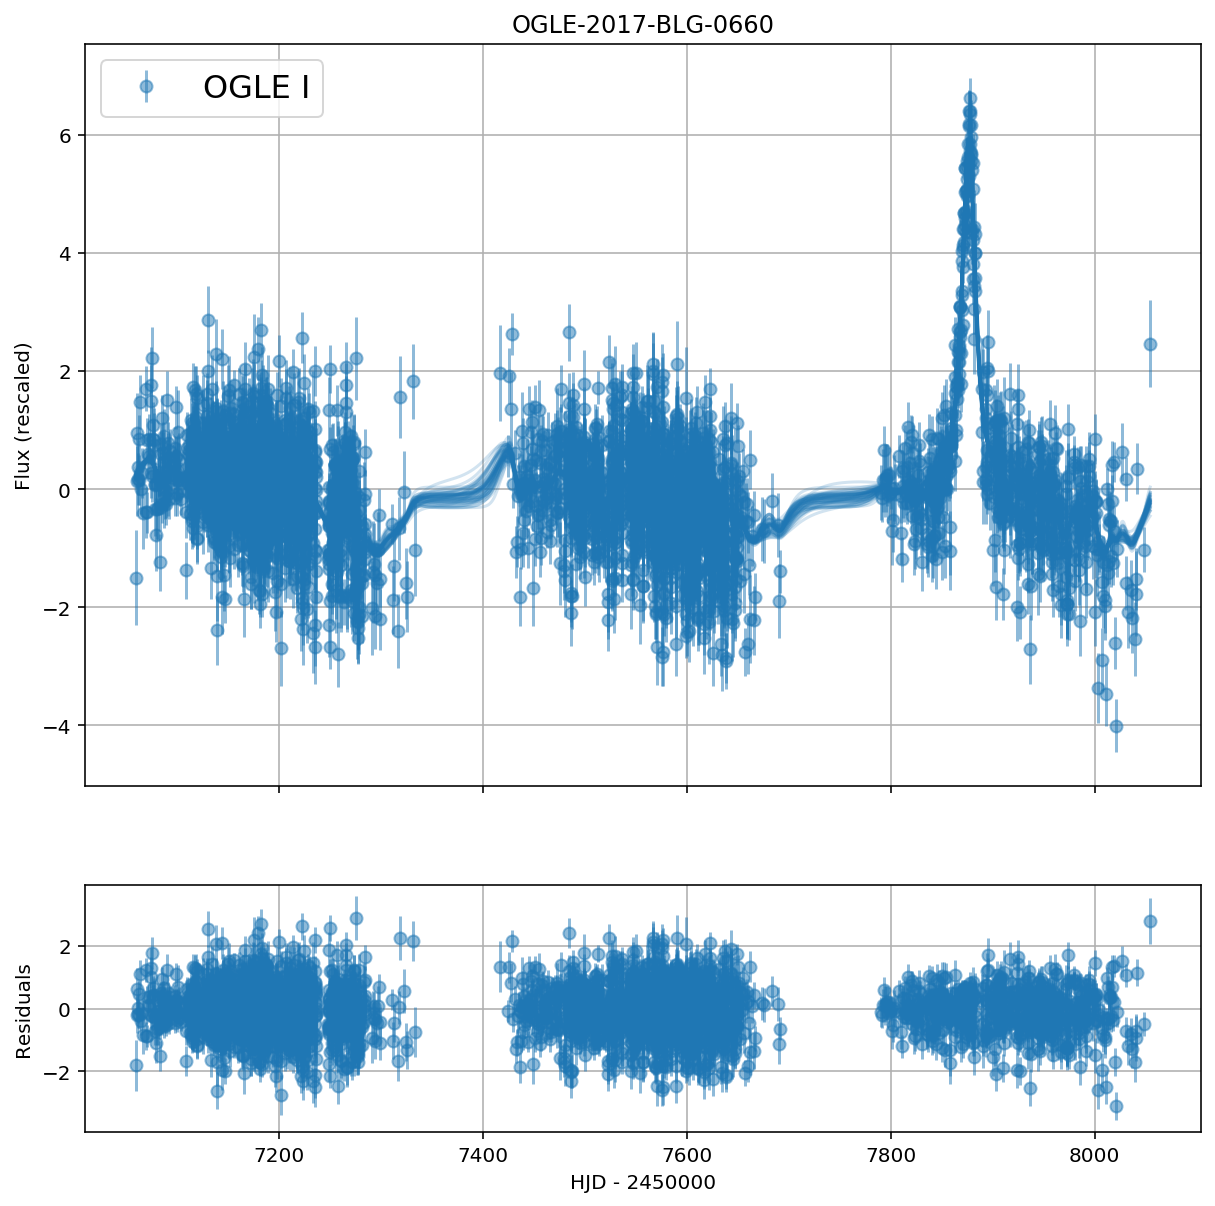

In [23]:
# Plot model
fig, ax = plt.subplots(2, 1, gridspec_kw={'height_ratios':[3,1]},
            figsize=(10, 8), sharex=True)

ca.plot_model_and_residuals(ax, event_ogle, model_gp, trace_gp,
                                  t_dense_tensor, mean_dense, n_samples=50, gp_list=gp_list)

KeyError: 'g\n0, 0'

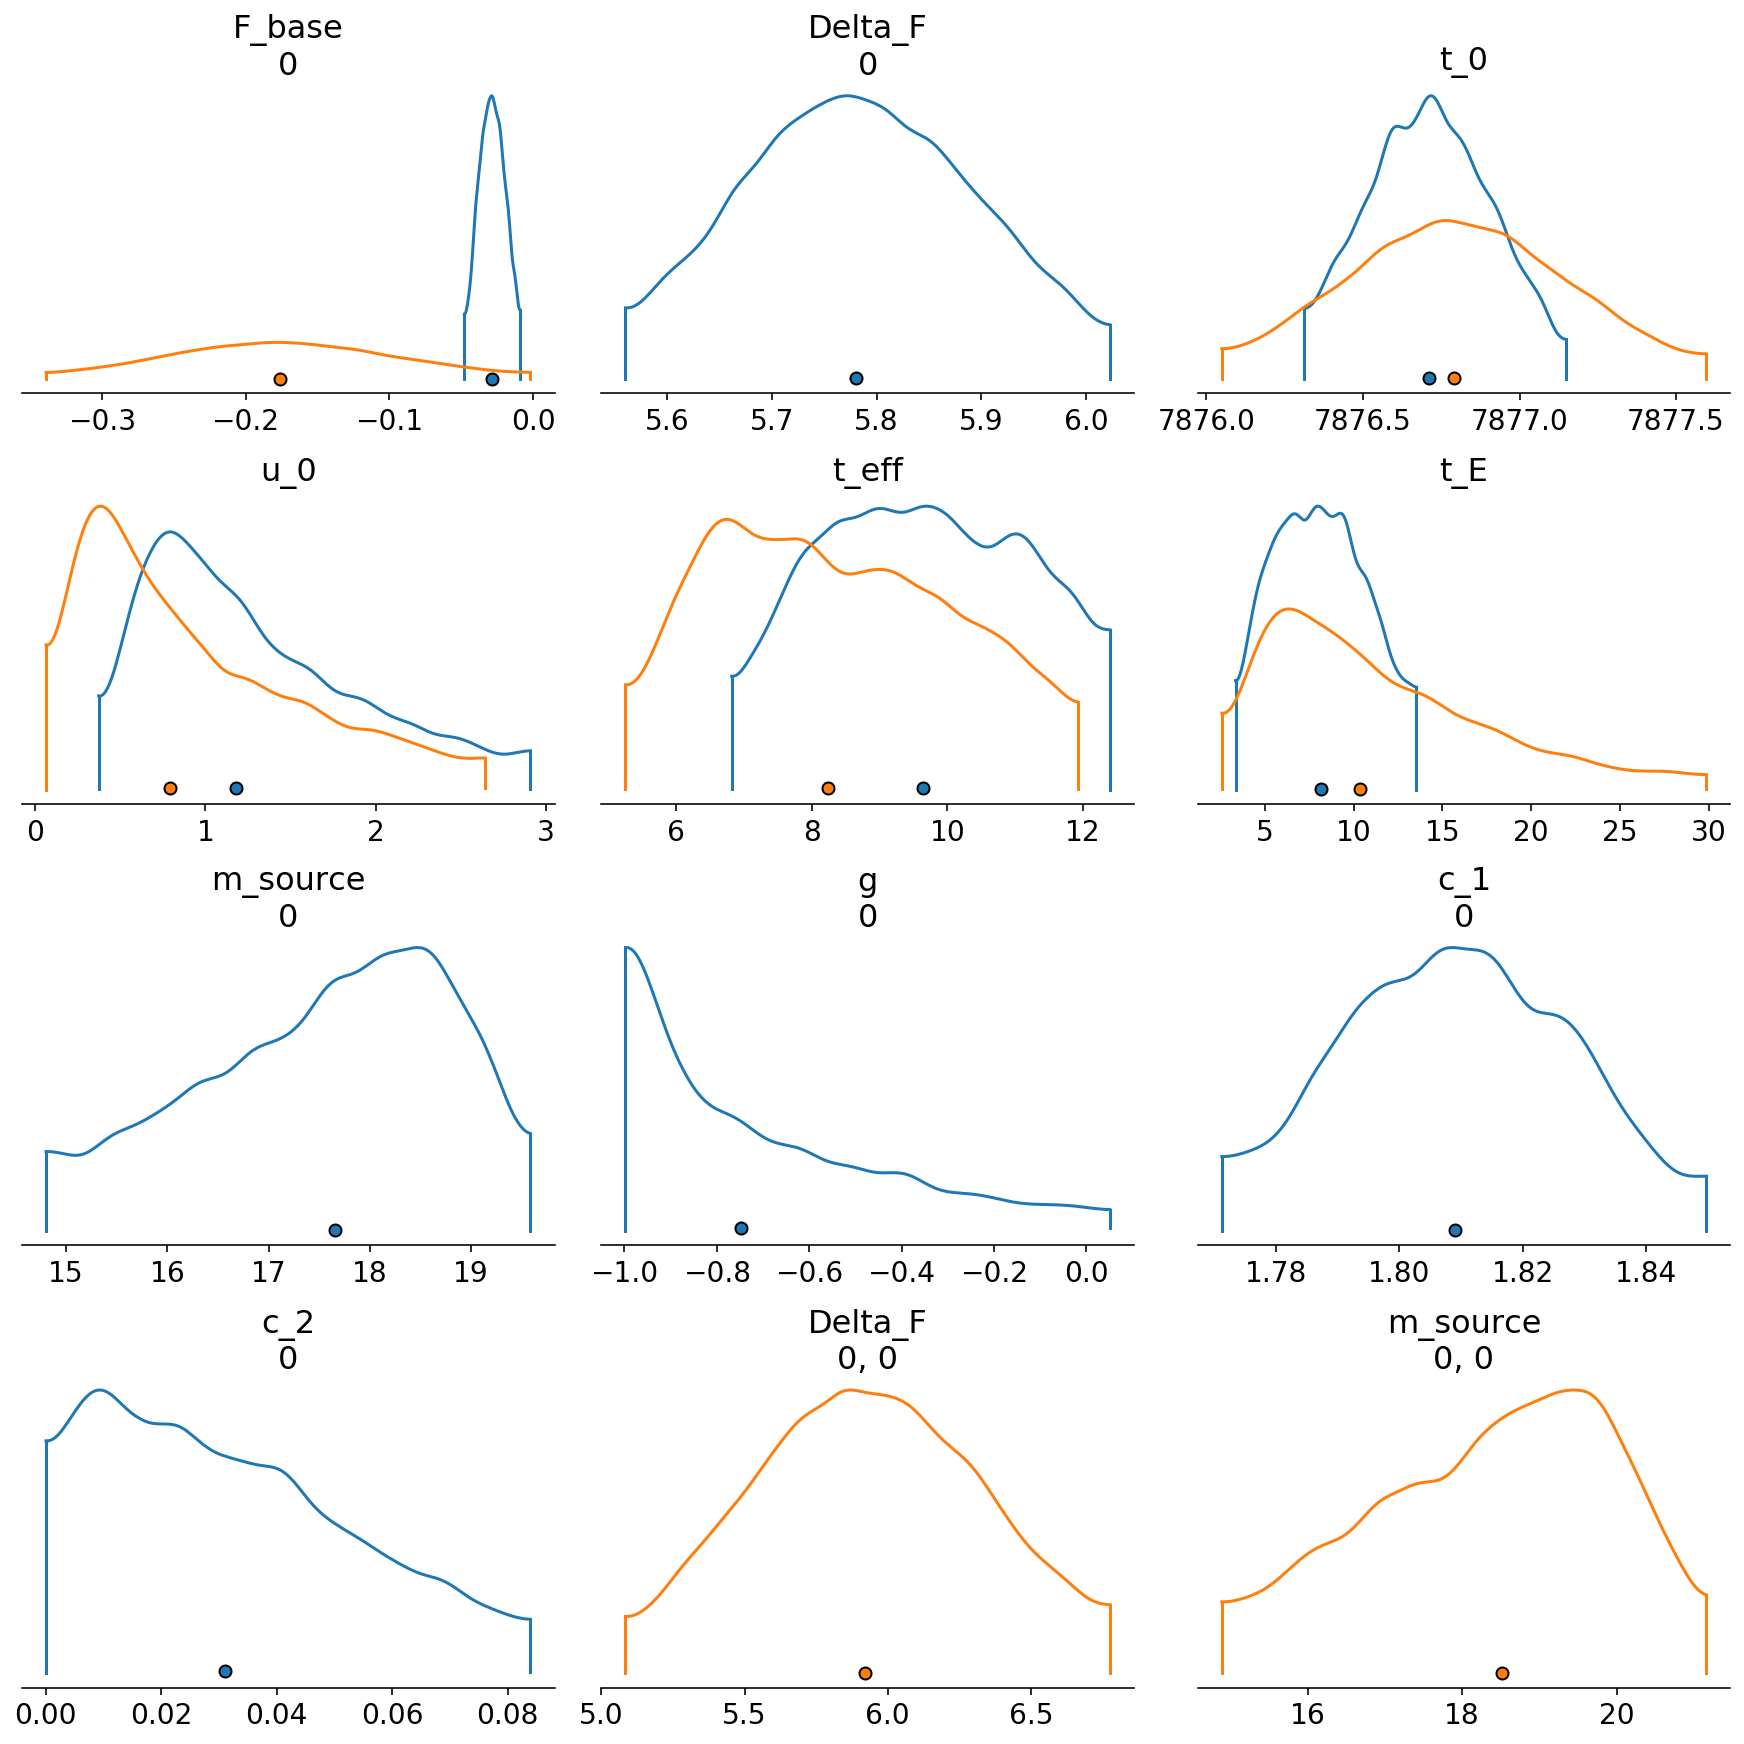

In [28]:
pm.plots.densityplot([trace, trace_gp], point_estimate='median', figsize=(12, 12),
                     data_labels=['white noise model', 'gp model']);

In this case, the GP easily converged and there are no clear patterns in the residuals of the model. We also see substantial differences in the posteriors for the physical parameters, the point estimates are different and the variance of parameters is generally larger for the GP model.